# Recommendation System for Books

In [1]:
# imports
import pandas as pd
import matplotlib.pyplot as plt
import sklearn.metrics as metrics
import numpy as np
from sklearn.neighbors import NearestNeighbors
from scipy.spatial.distance import correlation
from sklearn.metrics.pairwise import pairwise_distances
import warnings
import numpy as np
import os, sys
import re
import seaborn as sns
warnings.filterwarnings('ignore')

#### Loading Data

#### Pre-processing Data

In [4]:
# Loading Data
books = pd.read_csv("BX-Books.csv", sep=';', error_bad_lines=False, encoding="latin-1")
books.columns = ['id', 'Title', 'Author', 'Published', 'Publisher', 'ImageURLs', 'ImageURLm', 'imageURLL']
books.drop(['ImageURLs', 'ImageURLm', 'imageURLL'], axis=1, inplace=True)
print(books.head())
users = pd.read_csv("BX-Users.csv", sep=';', error_bad_lines=False, encoding="latin-1")
users.columns = ['id', 'Location', 'Age']
print(users.head())
ratings = pd.read_csv("BX-Book-Ratings.csv", sep=';', error_bad_lines=False, encoding="latin-1")
ratings.columns = ['UserID', 'BookID', 'BookRating']
print(ratings.head())

b'Skipping line 6452: expected 8 fields, saw 9\nSkipping line 43667: expected 8 fields, saw 10\nSkipping line 51751: expected 8 fields, saw 9\n'
b'Skipping line 92038: expected 8 fields, saw 9\nSkipping line 104319: expected 8 fields, saw 9\nSkipping line 121768: expected 8 fields, saw 9\n'
b'Skipping line 144058: expected 8 fields, saw 9\nSkipping line 150789: expected 8 fields, saw 9\nSkipping line 157128: expected 8 fields, saw 9\nSkipping line 180189: expected 8 fields, saw 9\nSkipping line 185738: expected 8 fields, saw 9\n'
b'Skipping line 209388: expected 8 fields, saw 9\nSkipping line 220626: expected 8 fields, saw 9\nSkipping line 227933: expected 8 fields, saw 11\nSkipping line 228957: expected 8 fields, saw 10\nSkipping line 245933: expected 8 fields, saw 9\nSkipping line 251296: expected 8 fields, saw 9\nSkipping line 259941: expected 8 fields, saw 9\nSkipping line 261529: expected 8 fields, saw 9\n'


           id                                              Title  \
0  0195153448                                Classical Mythology   
1  0002005018                                       Clara Callan   
2  0060973129                               Decision in Normandy   
3  0374157065  Flu: The Story of the Great Influenza Pandemic...   
4  0393045218                             The Mummies of Urumchi   

                 Author Published                   Publisher  
0    Mark P. O. Morford      2002     Oxford University Press  
1  Richard Bruce Wright      2001       HarperFlamingo Canada  
2          Carlo D'Este      1991             HarperPerennial  
3      Gina Bari Kolata      1999        Farrar Straus Giroux  
4       E. J. W. Barber      1999  W. W. Norton &amp; Company  
   id                            Location   Age
0   1                  nyc, new york, usa   NaN
1   2           stockton, california, usa  18.0
2   3     moscow, yukon territory, russia   NaN
3   4          

In [5]:
# Cleaning Books Dataframe
pd.set_option('display.max_colwidth', -1)
print(books.dtypes)
print(books.Published.unique())
# Some year of publication values have the publisher values instead
# Correcting DK Publishing
books.loc[books.Published == 'DK Publishing Inc']
books.loc[books.id == '078946697X', 'Published'] = 2000
books.loc[books.id == '078946697X', 'Author'] = 'Michael Teitelbaum'
books.loc[books.id == '078946697X', 'Publisher'] = 'DK Publishing Inc'
books.loc[books.id == '078946697X', 'Title'] = 'DK Readers: Creating the X-Men, How It All Began (Level 4: Proficient Readers)'
books.loc[books.id == '0789466953', 'Published'] = 2000
books.loc[books.id == '0789466953', 'Author'] = 'James Buckley'
books.loc[books.id == '0789466953', 'Publisher'] = 'DK Publishing Inc'
books.loc[books.id == '0789466953', 'Title'] = 'DK Readers: Creating the X-Men, How Comic Books Come to Life (Level 4: Proficient Readers)'
# Correct Gallimard
books.loc[books.Published == 'Gallimard']
books.loc[books.id == '2070426769', 'Published'] = 2003
books.loc[books.id == '2070426769', 'Author'] = 'Jean-Marie Gustave Le ClÃ?Â©zio'
books.loc[books.id == '2070426769', 'Publisher'] = 'Gallimard'
books.loc[books.id == '2070426769', 'Title'] = "Peuple du ciel, suivi de 'Les Bergers"
books.Published = pd.to_numeric(books.Published, errors='coerce')
print(sorted(books['Published'].unique()))
books.loc[books.Publisher.isnull()]
books.loc[(books.id == '193169656X'), 'Publisher'] = 'Other'
books.loc[(books.id == '1931696993'), 'Publisher'] = 'Other'

id           object
Title        object
Author       object
Published    object
Publisher    object
dtype: object
[2002 2001 1991 1999 2000 1993 1996 1988 2004 1998 1994 2003 1997 1983
 1979 1995 1982 1985 1992 1986 1978 1980 1952 1987 1990 1981 1989 1984 0
 1968 1961 1958 1974 1976 1971 1977 1975 1965 1941 1970 1962 1973 1972
 1960 1966 1920 1956 1959 1953 1951 1942 1963 1964 1969 1954 1950 1967
 2005 1957 1940 1937 1955 1946 1936 1930 2011 1925 1948 1943 1947 1945
 1923 2020 1939 1926 1938 2030 1911 1904 1949 1932 1928 1929 1927 1931
 1914 2050 1934 1910 1933 1902 1924 1921 1900 2038 2026 1944 1917 1901
 2010 1908 1906 1935 1806 2021 '2000' '1995' '1999' '2004' '2003' '1990'
 '1994' '1986' '1989' '2002' '1981' '1993' '1983' '1982' '1976' '1991'
 '1977' '1998' '1992' '1996' '0' '1997' '2001' '1974' '1968' '1987' '1984'
 '1988' '1963' '1956' '1970' '1985' '1978' '1973' '1980' '1979' '1975'
 '1969' '1961' '1965' '1939' '1958' '1950' '1953' '1966' '1971' '1959'
 '1972' '1955' '1957' '194

In [6]:
# Cleaning Users Dataframe
print(users.id.values)
# Removing ages below 5 and above 90 and replacing with mean values
users.loc[(users.Age > 90) | (users.Age < 5), 'Age'] = np.nan
users.Age = users.Age.fillna(users.Age.mean())
users.Age = users.Age.astype(np.int32)
print(sorted(users.Age.unique()))

[     1      2      3 ... 278856 278857 278858]
[5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90]


In [7]:
print(ratings.shape)
n_users = users.shape[0]
n_books = books.shape[0]
print(n_users * n_books)
print(ratings.head(5))

(1149780, 3)
75670906880
   UserID      BookID  BookRating
0  276725  034545104X  0         
1  276726  0155061224  5         
2  276727  0446520802  0         
3  276729  052165615X  3         
4  276729  0521795028  6         


In [8]:
ratings_new = ratings[ratings.BookID.isin(books.id)]
ratings_new = ratings_new[ratings_new.UserID.isin(users.id)]

In [9]:
print(ratings.shape)
print(ratings_new.shape)
print(ratings.BookRating.unique())
ratings_explicit = ratings_new[ratings_new.BookRating != 0]
ratings_implicit = ratings_new[ratings_new.BookRating == 0]
users_explicit_ratings = users[users.id.isin(ratings_explicit.UserID)]
users_implicit_ratings = users[users.id.isin(ratings_implicit.UserID)]

(1149780, 3)
(1031136, 3)
[ 0  5  3  6  8  7 10  9  4  1  2]


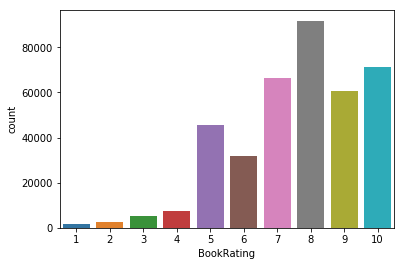

In [10]:
sns.countplot(data=ratings_explicit, x="BookRating")
plt.show()

## Recommendation System based on high-ratings (not user-specific) 

In [11]:
ratings_count = pd.DataFrame(ratings_explicit.groupby(['BookID'])['BookRating'].sum())
best_10_books = ratings_count.sort_values('BookRating', ascending = False)
#best_10_books.merge(books, left_index = True, right_on = 'id')
print("Following books are the most highly rated")
print(best_10_books.merge(books, left_index = True, right_on = 'id').head(10))

Following books are the most highly rated
      BookRating          id  \
408   5787        0316666343   
748   4108        0385504209   
522   3134        0312195516   
2143  2798        059035342X   
356   2595        0142001740   
26    2551        0971880107   
1105  2524        0060928336   
706   2402        0446672211   
231   2219        0452282152   
118   2179        0671027360   

                                                                 Title  \
408   The Lovely Bones: A Novel                                          
748   The Da Vinci Code                                                  
522   The Red Tent (Bestselling Backlist)                                
2143  Harry Potter and the Sorcerer's Stone (Harry Potter (Paperback))   
356   The Secret Life of Bees                                            
26    Wild Animus                                                        
1105  Divine Secrets of the Ya-Ya Sisterhood: A Novel                    
706   Where t

## User-based Collaborative Filtering Recommendation System

In [12]:
user_counts = ratings_explicit['UserID'].value_counts()
ratings_explicit = ratings_explicit[ratings_explicit['UserID'].isin(user_counts[user_counts >= 100].index)]
ratings_counts = ratings_explicit['BookRating'].value_counts()
ratings_explicit = ratings_explicit[ratings_explicit['BookRating'].isin(ratings_counts[ratings_counts >= 100].index)]

In [13]:
ratings_matrix = ratings_explicit.pivot(index = 'UserID', columns = 'BookID', values = 'BookRating')
userID = ratings_matrix.index
bookID = ratings_matrix.columns
print(ratings_matrix.head(5))

BookID  0000913154  0001046438  000104687X  0001047213  0001047973  \
UserID                                                               
2033   NaN         NaN         NaN         NaN         NaN           
2110   NaN         NaN         NaN         NaN         NaN           
2276   NaN         NaN         NaN         NaN         NaN           
4017   NaN         NaN         NaN         NaN         NaN           
4385   NaN         NaN         NaN         NaN         NaN           

BookID  000104799X  0001048082  0001053736  0001053744  0001055607  ...  \
UserID                                                              ...   
2033   NaN         NaN         NaN         NaN         NaN          ...   
2110   NaN         NaN         NaN         NaN         NaN          ...   
2276   NaN         NaN         NaN         NaN         NaN          ...   
4017   NaN         NaN         NaN         NaN         NaN          ...   
4385   NaN         NaN         NaN         NaN         NaN 

In [14]:
ratings_matrix = ratings_matrix.fillna(0)

In [15]:
ratings_matrix.head(5)

BookID,0000913154,0001046438,000104687X,0001047213,0001047973,000104799X,0001048082,0001053736,0001053744,0001055607,...,B000092Q0A,B00009EF82,B00009NDAN,B0000DYXID,B0000T6KHI,B0000VZEJQ,B0000X8HIE,B00013AX9E,B0001I1KOG,B000234N3A
UserID,,,,,,,,,,,,,,,,,,,,,
2033,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2110,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2276,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4017,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4385,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [16]:
global metric, k
k = 10
metric = 'cosine'

Methods for recommendation
1 : Book-based (using correlation)
2 : Book-based (using cosine similarity)
3 : User-based (using correlation)
4 : User-based (using cosine similarity)

In [35]:
def findSimilarUsers(userID, ratings, metric = metric, k = k):
    neighbors = []
    indices = []
    model = NearestNeighbors(metric = metric, algorithm = 'brute')
    model.fit(ratings)
    loc = ratings.index.get_loc(userID)
    distances, indices = model.kneighbors(ratings.iloc[loc, :].values.reshape(1, -1), n_neighbors = k+1)
    neighbors = 1-distances.flatten()
    
    return neighbors, indices

In [36]:
def predictUserRatingForBook_UB(userID, bookID, ratings, metric = metric, k = k):
    predicted_rating = 0
    user = ratings.index.get_loc(userID)
    book = ratings.columns.get_loc(bookID)
    neighbors, indices = findSimilarUsers(userID, ratings, 'correlation', 10)
    mean_rating = ratings.iloc[user,:].mean()
    sum_wt = np.sum(neighbors)-1
    product = 1
    weighted_sum = 0
    for i in range(len(indices.flatten())):
        if indices.flatten()[i] == user:
            continue
        else:
            ratings_difference = ratings.iloc[indices.flatten()[i], book] - np.mean(ratings.iloc[indices.flatten()[i],:])
            product = ratings_difference * neighbors[i]
            weighted_sum = weighted_sum + product
    
    predicted_rating = int(round(mean_rating + weighted_sum/sum_wt))
    if predicted_rating <=0:
        predicted_rating = 0
    elif predicted_rating >=10:
        predicted_rating = 10
        
    #print("Predicted rating for user: ", userID, "for book : ", bookID, "is : ",predicted_rating)
    return predicted_rating

In [38]:
def findSimilarBooks(BookID, ratings, metric = metric, k = k):
    neighbors = []
    indices = []
    ratings = ratings.T
    book = ratings.index.get_loc(BookID)
    model = NearestNeighbors(metric = metric, algorithm = 'brute')
    model.fit(ratings)
    distances, indices = model.kneighbors(ratings.iloc[book, :].values.reshape(1,-1), n_neighbors = k+1)
    neighbors = 1-distances.flatten()
    
    return neighbors, indices

In [40]:
def predictUserRatingForBook_BB(userID, bookID, ratings, metric = metric, k = k):
    predicted_rating = 0
    user = ratings.index.get_loc(userID)
    book = ratings.columns.get_loc(bookID)
    neighbors, indices = findSimilarUsers(userID, ratings, 'correlation', 10)
    mean_rating = ratings.iloc[user,:].mean()
    sum_wt = np.sum(neighbors)-1
    product = 1
    weighted_sum = 0
    for i in range(len(indices.flatten())):
        if indices.flatten()[i] == book:
            continue
        else:
            product = ratings.iloc[user,indices.flatten()[i]] * (neighbors[i])
            weighted_sum = weighted_sum + product
    
    predicted_rating = int(round(mean_rating + weighted_sum/sum_wt))
    if predicted_rating <=0:
        predicted_rating = 0
    elif predicted_rating >=10:
        predicted_rating = 10
        
    #print("Predicted rating for user: ", userID, "for book : ", bookID, "is : ",predicted_rating)
    return predicted_rating

In [47]:
def recommendBook(user_id, ratings, method, metric=metric):
    if (user_id not in ratings.index.values) or type(user_id) is not int:
        print("Invalid User ID")
    else:
        i=0
        prediction = []
        if (method == 1 or method == 3):
            metric = 'correlation'
        else:
            metric = 'cosine'
        if (method == 1 or method == 2):
            for i in range(ratings.shape[1]):
                if (ratings[str(ratings.columns[i])][user_id] !=0):
                    prediction.append(predictUserRatingForBook_BB(user_id, str(ratings.columns[i]) ,ratings, metric))
                else:
                    prediction.append(-1)
        else:
            for i in range(ratings.shape[1]):
                if (ratings[str(ratings.columns[i])][user_id] !=0):
                    prediction.append(predictUserRatingForBook_UB(user_id, str(ratings.columns[i]) ,ratings, metric))
                else:
                    prediction.append(-1)
        prediction = pd.Series(prediction)
        prediction = prediction.sort_values(ascending=False)
        recommended = prediction[:10]
        print("recommendations")
        for i in range(len(recommended)):
            print(i+1, books.Title[recommended.index[i]]) 

In [44]:
recommendBook(4385, ratings_matrix, 1)

recommendations
1 My Wicked Wicked Ways
2 El perfume
3 Arena y viento (Los Jet de Plaza &amp; JanÃ©s)
4 La Fata Carabina
5 Mi mamÃ¡ me ama (Nueva narrativa hispÃ¡nica)
6 Donde El Corazon Te Lleve
7 Fair Peril
8 Equal Rites (Discworld Novels (Paperback))
9 Mazurka for Two Dead Men
10 Perfect Harmony


In [45]:
recommendBook(4385, ratings_matrix, 2)

recommendations
1 My Wicked Wicked Ways
2 El perfume
3 Arena y viento (Los Jet de Plaza &amp; JanÃ©s)
4 La Fata Carabina
5 Mi mamÃ¡ me ama (Nueva narrativa hispÃ¡nica)
6 Donde El Corazon Te Lleve
7 Fair Peril
8 Equal Rites (Discworld Novels (Paperback))
9 Mazurka for Two Dead Men
10 Perfect Harmony


In [48]:
recommendBook(4235, ratings_matrix, 3)

Invalid User ID


In [ ]:
recommendBook(4385, ratings_matrix, 4)